In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import optuna
import sys
sys.path.append(r'c:\\Users\\Sanju\\OneDrive\\Documents\\DataScientist\\3-PORTOFOLIO\\TrenHargaRumah')
from src.utils import hist_box_plot, bar_plot, heatmap, cramers_v,violin_plot,scatter_plot

c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("..//data//clean.csv")
df.head()

,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan
0,"Medan Johor, Medan",21.639557,Ruko,0.0,3.0,0.0,4.174387,5.351858
1,"Medan Maimun, Medan",20.863028,Ruko,0.0,4.0,0.0,4.290459,5.262690
2,"Medan Tembung, Medan",20.617905,Rumah,2.0,3.0,1.0,4.043051,4.615121
3,"Medan Baru, Medan",22.031599,Rumah,5.0,5.0,2.0,5.860786,5.707110
4,"Medan Timur, Medan",21.752885,Ruko,0.0,1.0,0.0,4.624973,5.590987


In [4]:
X = df.drop('harga',axis=1)
y = df['harga']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2, random_state=42)
def generate_pipeline(model = None):
    transformers = ColumnTransformer([
        ('scaler',StandardScaler(),['jumlah_kamar_tidur','jumlah_kamar_mandi','garasi','luas_tanah','luas_bangunan']),
        ('one_hot',OneHotEncoder(),['lokasi','jenis_properti'])
    ])
    pipeline = Pipeline([
        ('transformer', transformers),
        ('model', model)
    ])
    return pipeline

lin_reg = generate_pipeline(LinearRegression())
lin_reg.fit(X_train,y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:
models = {
    'lin_reg': LinearRegression(),
    'svm' : SVR(),
    'rf' : RandomForestRegressor(random_state=42),
    'xgb' : XGBRegressor(random_state=42)
}

for name,model in models.items():
    pipeline = generate_pipeline(model)
    score = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
    print(f"{name}: {score}")
    print(f"    rata-rata: {np.mean(score)}")

lin_reg: [0.70860184 0.67745209 0.67834099 0.69504577 0.68557154]
    rata-rata: 0.6890024448158054
svm: [0.76665582 0.73664789 0.74243333 0.74657158 0.73842849]
    rata-rata: 0.7461474228992995
rf: [0.79559117 0.77314131 0.76979103 0.76271039 0.75746058]
    rata-rata: 0.7717388943913619
xgb: [0.78534388 0.76371487 0.76581588 0.74693823 0.74964443]
    rata-rata: 0.7622914576138516


In [62]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)  # max_depth biasanya 3-20 untuk xgb
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)  # learning rate penting untuk xgb
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # untuk menghindari overfitting
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        verbosity=0,
        use_label_encoder=False
    )
    
    pipeline = generate_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best params : {study.best_params}')
print(f'Best R2 (CV): {study.best_value}')

[I 2025-06-07 15:08:20,822] A new study created in memory with name: no-name-c52f3166-ac54-4f5b-8f85-a802ffd5ab52
[I 2025-06-07 15:08:27,891] Trial 0 finished with value: 0.7739720314970138 and parameters: {'n_estimators': 193, 'max_depth': 17, 'learning_rate': 0.09835654554987099, 'subsample': 0.5493410593130063, 'colsample_bytree': 0.5587937921175785}. Best is trial 0 with value: 0.7739720314970138.
[I 2025-06-07 15:08:34,247] Trial 1 finished with value: 0.7429431122605759 and parameters: {'n_estimators': 149, 'max_depth': 19, 'learning_rate': 0.012505312758070375, 'subsample': 0.5389259101493271, 'colsample_bytree': 0.671039565856562}. Best is trial 0 with value: 0.7739720314970138.
[I 2025-06-07 15:08:37,843] Trial 2 finished with value: 0.7662777451670812 and parameters: {'n_estimators': 51, 'max_depth': 18, 'learning_rate': 0.12235990440274806, 'subsample': 0.7037746331989956, 'colsample_bytree': 0.9399671670077518}. Best is trial 0 with value: 0.7739720314970138.
[I 2025-06-07 

Best params : {'n_estimators': 195, 'max_depth': 17, 'learning_rate': 0.026206305032291384, 'subsample': 0.7639105783263083, 'colsample_bytree': 0.5275565448553503}
Best R2 (CV): 0.787099671484149


In [ ]:
xgb_model = XGBRegressor(**study.best_params,random_state=42)
rf_model = RandomForestRegressor(random_state=42)

In [79]:
xgb_model_pipeline = generate_pipeline(xgb_model)
xgb_model_pipeline.fit(X_train,y_train)
y_pred= xgb_model_pipeline.predict(X_test)
r2_score(y_test,y_pred)

0.7781598156325007

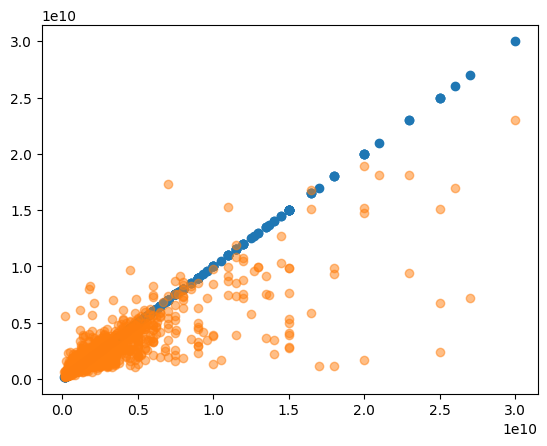

In [88]:
plt.scatter(np.expm1(y_test),np.expm1(y_test),alpha=1)
plt.scatter(np.expm1(y_test),np.expm1(y_pred),alpha=.5)

R2-Score Apartemen: 0.9288065723547868


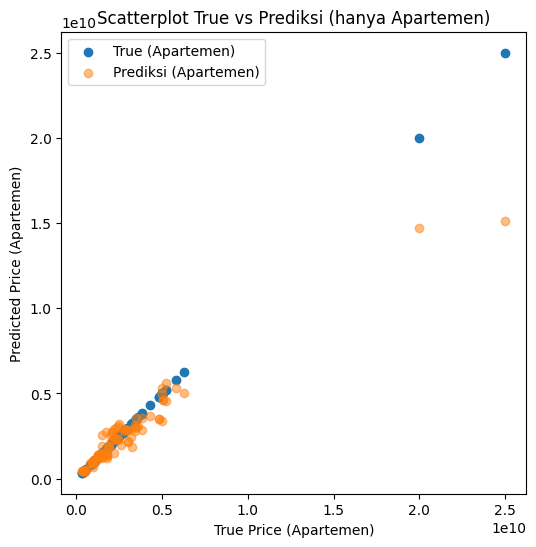

In [91]:
mask_apartemen = X_test['jenis_properti'] == 'Apartemen'

y_test_apartemen = y_test[mask_apartemen]
y_pred_apartemen = y_pred[mask_apartemen]

print(f"R2-Score Apartemen: {r2_score(y_test_apartemen,y_pred_apartemen)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_test_apartemen), alpha=1, label="True (Apartemen)")
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_pred_apartemen), alpha=0.5, label="Prediksi (Apartemen)")
plt.xlabel('True Price (Apartemen)')
plt.ylabel('Predicted Price (Apartemen)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Apartemen)")
plt.show()


R2-Score Rumah: 0.7933803101308753


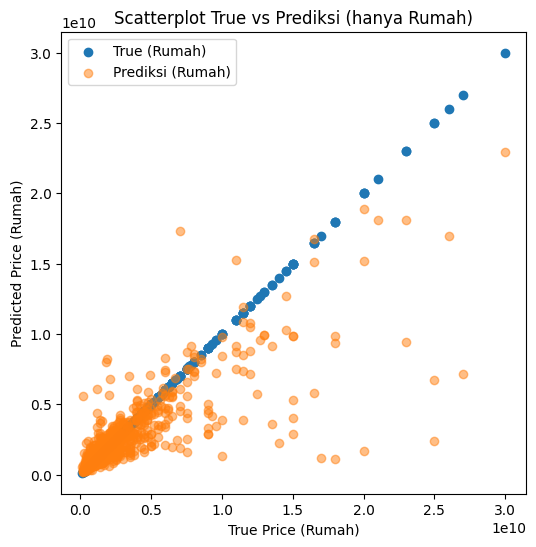

In [93]:
mask_Rumah = X_test['jenis_properti'] == 'Rumah'

y_test_Rumah = y_test[mask_Rumah]
y_pred_Rumah = y_pred[mask_Rumah]

print(f"R2-Score Rumah: {r2_score(y_test_Rumah,y_pred_Rumah)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_test_Rumah), alpha=1, label="True (Rumah)")
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_pred_Rumah), alpha=0.5, label="Prediksi (Rumah)")
plt.xlabel('True Price (Rumah)')
plt.ylabel('Predicted Price (Rumah)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Rumah)")
plt.show()


R2-Score Ruko: 0.6083606631119772


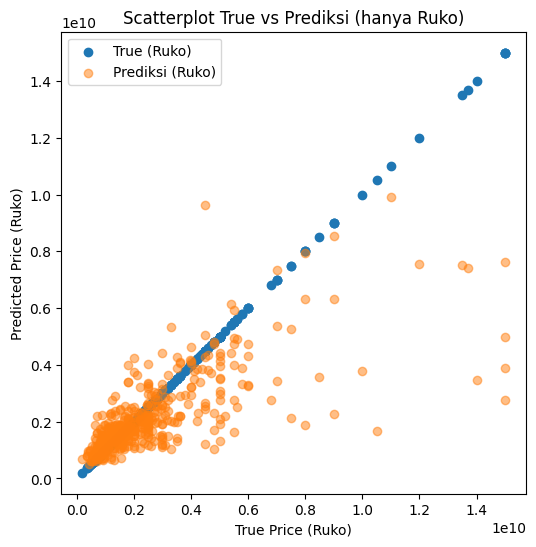

In [92]:
mask_Ruko = X_test['jenis_properti'] == 'Ruko'

y_test_Ruko = y_test[mask_Ruko]
y_pred_Ruko = y_pred[mask_Ruko]

print(f"R2-Score Ruko: {r2_score(y_test_Ruko,y_pred_Ruko)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_test_Ruko), alpha=1, label="True (Ruko)")
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_pred_Ruko), alpha=0.5, label="Prediksi (Ruko)")
plt.xlabel('True Price (Ruko)')
plt.ylabel('Predicted Price (Ruko)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Ruko)")
plt.show()
